#### Data Exploration on Mini Val 2017 LVIS Dataset

##### Setup and Import

In [76]:
import json
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

from PIL import Image
from pathlib import Path

In [2]:
label_dir = Path("/Users/olivia/Documents/MS-ADS @Uchicago/Capstone /datasets/lvis/labels/val2017")
image_dir = Path("/Users/olivia/Documents/MS-ADS @Uchicago/Capstone /datasets/lvis/images/val2017")

label_files = list(label_dir.glob("*.txt"))
image_files = list(image_dir.glob("*.jpg"))

print(f"Label files: {len(label_files)}")
print(f"Image files: {len(image_files)}")

Label files: 4752
Image files: 5000


In [3]:
json_path = "/Users/olivia/Documents/MS-ADS @Uchicago/Capstone /datasets/lvis/annotations/lvis_v1_minival.json"

with open(json_path, 'r') as f:
    lvis_data = json.load(f)

categories = lvis_data['categories']
class_names = [cat['name'] for cat in categories]
class_id_map = {cat['id']: i for i, cat in enumerate(categories)}  # Optional: map original ID to 0-indexed

print(f"Total LVIS classes: {len(class_names)}")
print(class_names[:10]) 

Total LVIS classes: 1203
['aerosol_can', 'air_conditioner', 'airplane', 'alarm_clock', 'alcohol', 'alligator', 'almond', 'ambulance', 'amplifier', 'anklet']


##### Analyze Image Dimensions & Aspect Ratios

Total images: 4809
Width range: 220 to 640
Height range: 159 to 640
Aspect ratio range: 0.38 to 4.03
Median aspect ratio: 1.33


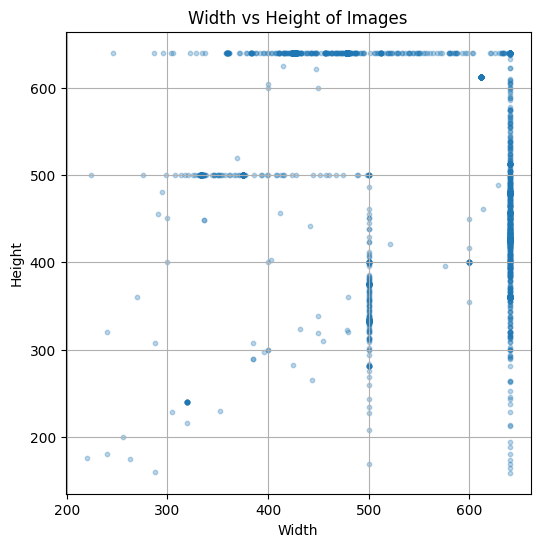

In [80]:
widths = [img['width'] for img in lvis_data['images']]
heights = [img['height'] for img in lvis_data['images']]
ratios = [w / h for w, h in zip(widths, heights)]

print(f"Total images: {len(widths)}")
print(f"Width range: {min(widths)} to {max(widths)}")
print(f"Height range: {min(heights)} to {max(heights)}")
print(f"Aspect ratio range: {min(ratios):.2f} to {max(ratios):.2f}")
print(f"Median aspect ratio: {np.median(ratios):.2f}")

plt.figure(figsize=(6,6))
plt.scatter(widths, heights, alpha=0.3, s=10)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Width vs Height of Images")
plt.grid(True)
plt.show()

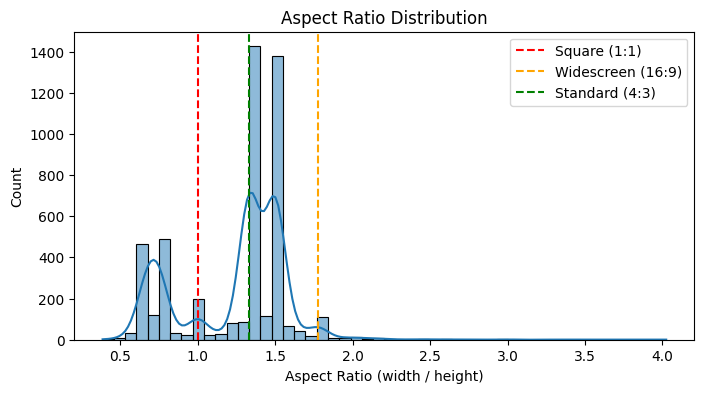

In [82]:
# Plot: Aspect ratio histogram
plt.figure(figsize=(8, 4))
sns.histplot(ratios, bins=50, kde=True)
plt.axvline(x=1.0, color='r', linestyle='--', label="Square (1:1)")
plt.axvline(x=16/9, color='orange', linestyle='--', label="Widescreen (16:9)")
plt.axvline(x=4/3, color='green', linestyle='--', label="Standard (4:3)")
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (width / height)")
plt.legend()
plt.show()

dataset contains a wide range of image dimensions, with widths and heights ranging from 220 to 640 pixels and aspect ratios spanning from 0.38 (very tall) to 4.03 (very wide). The median aspect ratio is approximately 1.33, indicating a slight bias toward horizontally oriented images, but the distribution is multi-modal. Given this variability, direct resizing would distort many images and potentially degrade detection performance—especially for small objects, which are abundant in LVIS. To address this, we recommend using a "resize with aspect ratio + padding" strategy (letterboxing) to standardize images to square inputs (e.g., 384×384) while preserving object shape and scale

In [20]:
category_counts = {i: 0 for i in range(len(class_names))} 

# Update this part of your loop to get class counts
for label_file in label_files:
    with open(label_file) as f:
        for line in f:
            class_id = int(line.strip().split()[0])
            category_counts[class_id] += 1

##### Top-20 category

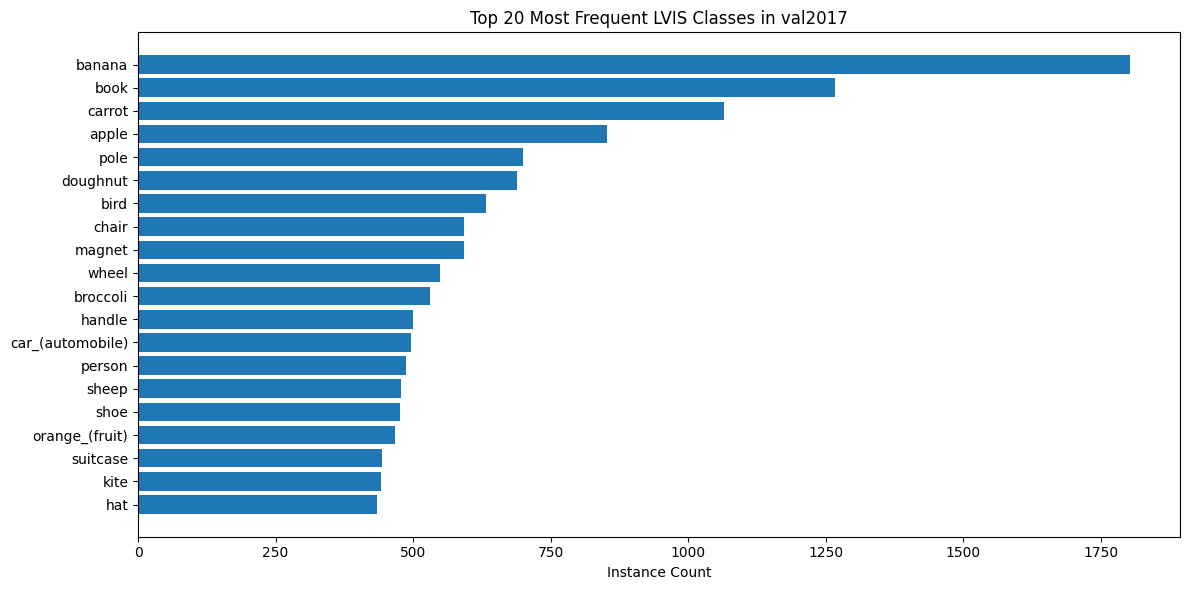

In [23]:
top_n = 20
top_classes = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_labels = [class_names[i] for i, _ in top_classes]
top_counts = [c for _, c in top_classes]

plt.figure(figsize=(12, 6))
plt.barh(top_labels[::-1], top_counts[::-1])
plt.xlabel("Instance Count")
plt.title("Top 20 Most Frequent LVIS Classes in val2017")
plt.tight_layout()
plt.show()

In [24]:
with open("/Users/olivia/Documents/MS-ADS @Uchicago/Capstone /datasets/lvis/lvis.names", "w") as f:
    f.write("\n".join(class_names))

##### Distributions of Number of Annotations

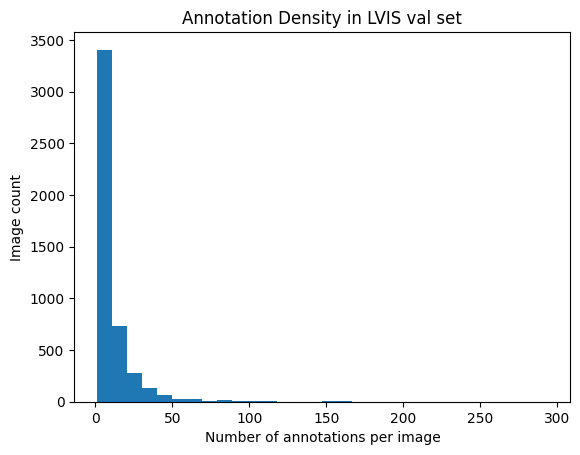

Max annotations in one image: 294
Avg annotations per image: 10.66


In [28]:
image_annotations = {}  

for ann in lvis_data['annotations']:
    image_id = ann['image_id']
    image_annotations[image_id] = image_annotations.get(image_id, 0) + 1

ann_counts = list(image_annotations.values())

plt.hist(ann_counts, bins=30)
plt.xlabel("Number of annotations per image")
plt.ylabel("Image count")
plt.title("Annotation Density in LVIS val set")
plt.show()

print(f"Max annotations in one image: {max(ann_counts)}")
print(f"Avg annotations per image: {sum(ann_counts)/len(ann_counts):.2f}")


##### Long-Tailed Distribution

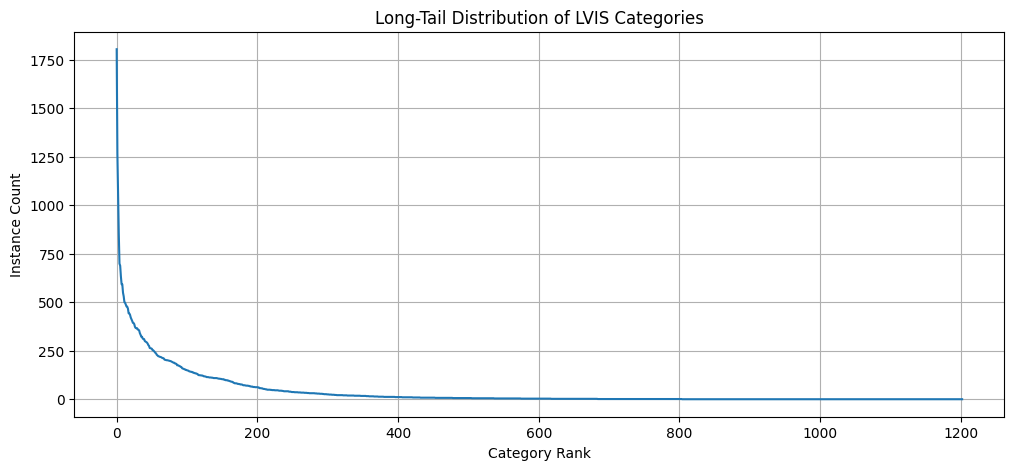

In [30]:
all_counts = sorted(category_counts.values(), reverse=True)

plt.figure(figsize=(12,5))
plt.plot(all_counts)
plt.xlabel("Category Rank")
plt.ylabel("Instance Count")
plt.title("Long-Tail Distribution of LVIS Categories")
plt.grid(True)
plt.show()

##### Bounding Box Size Distribution

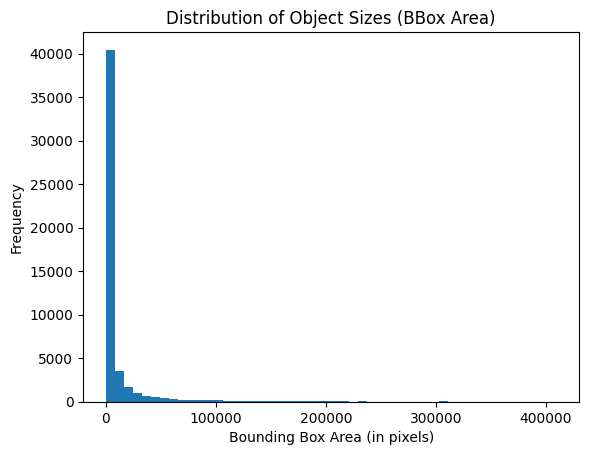

Avg bbox area: 10514.75


In [32]:
bbox_areas = []

for ann in lvis_data['annotations']:
    _, _, width, height = ann['bbox']
    bbox_areas.append(width * height)

plt.hist(bbox_areas, bins=50)
plt.xlabel("Bounding Box Area (in pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Object Sizes (BBox Area)")
plt.show()

print(f"Avg bbox area: {sum(bbox_areas)/len(bbox_areas):.2f}")

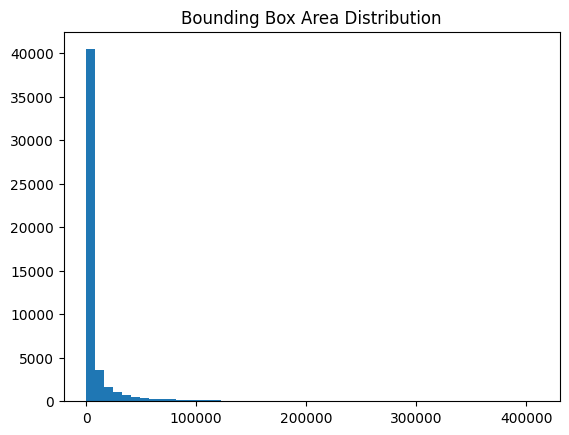

In [58]:
import numpy as np

bbox_areas = [ann['bbox'][2] * ann['bbox'][3] for ann in lvis_data['annotations']]
plt.hist(bbox_areas, bins=50)
plt.title("Bounding Box Area Distribution")
plt.show()

##### Visualize Sample Annotated Image (with BBoxes)

In [35]:
image_info = lvis_data['images'][0]  # or use random.choice(lvis_data['images'])
print(image_info.keys())

dict_keys(['date_captured', 'neg_category_ids', 'id', 'license', 'height', 'width', 'flickr_url', 'coco_url', 'not_exhaustive_category_ids', 'file_name'])


In [37]:
annotated_ids = set(ann['image_id'] for ann in lvis_data['annotations'])
all_image_ids = set(img['id'] for img in lvis_data['images'])

no_annotation_ids = all_image_ids - annotated_ids
print(f"Images with no annotations: {len(no_annotation_ids)} out of {len(all_image_ids)}")

Images with no annotations: 57 out of 4809


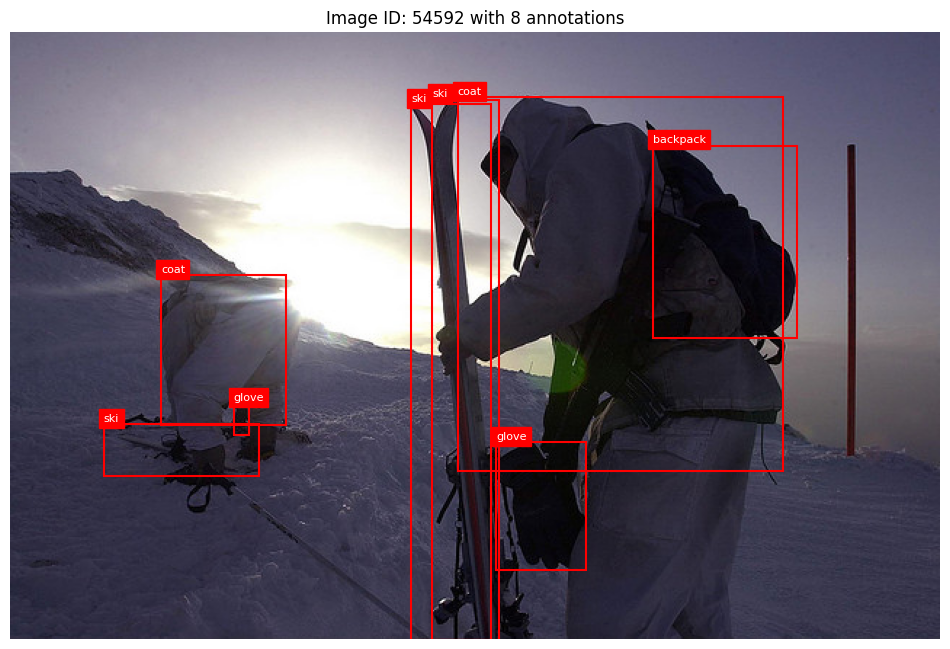

val2017/000000054592.jpg


In [52]:
# Pick a random image with annotations
image_info = random.choice(lvis_data['images'])
image_id = image_info['id']
file_name = image_info['file_name']

anns = [ann for ann in lvis_data['annotations'] if ann['image_id'] == image_id]

img_path = f"/Users/olivia/Documents/MS-ADS @Uchicago/Capstone /datasets/lvis/images/{file_name}"

img = Image.open(img_path)

# Plot
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img)

for ann in anns:
    x, y, w, h = ann['bbox']
    class_id = ann['category_id']
    try:
        class_name = next(c['name'] for c in lvis_data['categories'] if c['id'] == class_id)
    except:
        class_name = str(class_id)
    
    rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y - 2, class_name, color='white', backgroundcolor='red', fontsize=8)

plt.axis('off')
plt.title(f"Image ID: {image_id} with {len(anns)} annotations")
plt.show()

print(file_name)  

In [62]:
PATCH_SIZE = 16  # typical for ViT-Base
INPUT_SIZE = 224  # assuming resized input for ViT
NUM_PATCHES = INPUT_SIZE // PATCH_SIZE  # 14x14 patches

In [64]:
object_patch_sizes = []

for ann in lvis_data['annotations']:
    bbox = ann['bbox']  # [x, y, width, height]
    image = next(img for img in lvis_data['images'] if img['id'] == ann['image_id'])

    # Normalize bbox to image size (since ViT will resize images to 224x224)
    w_norm = bbox[2] / image['width']
    h_norm = bbox[3] / image['height']

    # Convert to number of patches
    w_patches = w_norm * NUM_PATCHES
    h_patches = h_norm * NUM_PATCHES

    area_in_patches = w_patches * h_patches
    object_patch_sizes.append(area_in_patches)


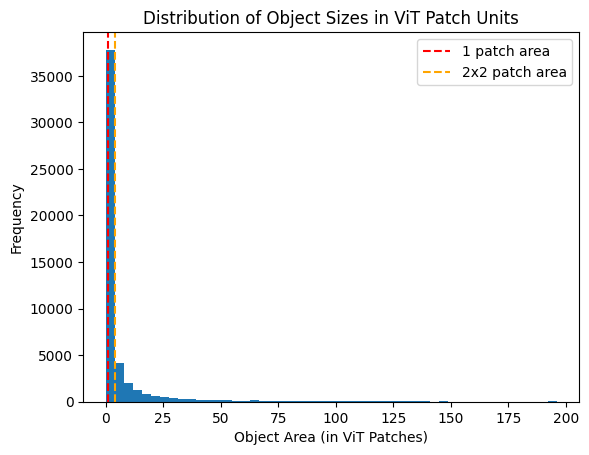

In [66]:
plt.hist(object_patch_sizes, bins=50)
plt.axvline(x=1, color='r', linestyle='--', label='1 patch area')
plt.axvline(x=4, color='orange', linestyle='--', label='2x2 patch area')
plt.title("Distribution of Object Sizes in ViT Patch Units")
plt.xlabel("Object Area (in ViT Patches)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [68]:
import numpy as np

small_objs = [a for a in object_patch_sizes if a < 1]
tiny_objs = [a for a in object_patch_sizes if a < 4]

print(f"Total objects: {len(object_patch_sizes)}")
print(f"Objects < 1 patch: {len(small_objs)} ({len(small_objs)/len(object_patch_sizes)*100:.2f}%)")
print(f"Objects < 4 patches (2x2): {len(tiny_objs)} ({len(tiny_objs)/len(object_patch_sizes)*100:.2f}%)")

Total objects: 50672
Objects < 1 patch: 27056 (53.39%)
Objects < 4 patches (2x2): 37948 (74.89%)


##### Size to Map (Check if augmentation is needed)

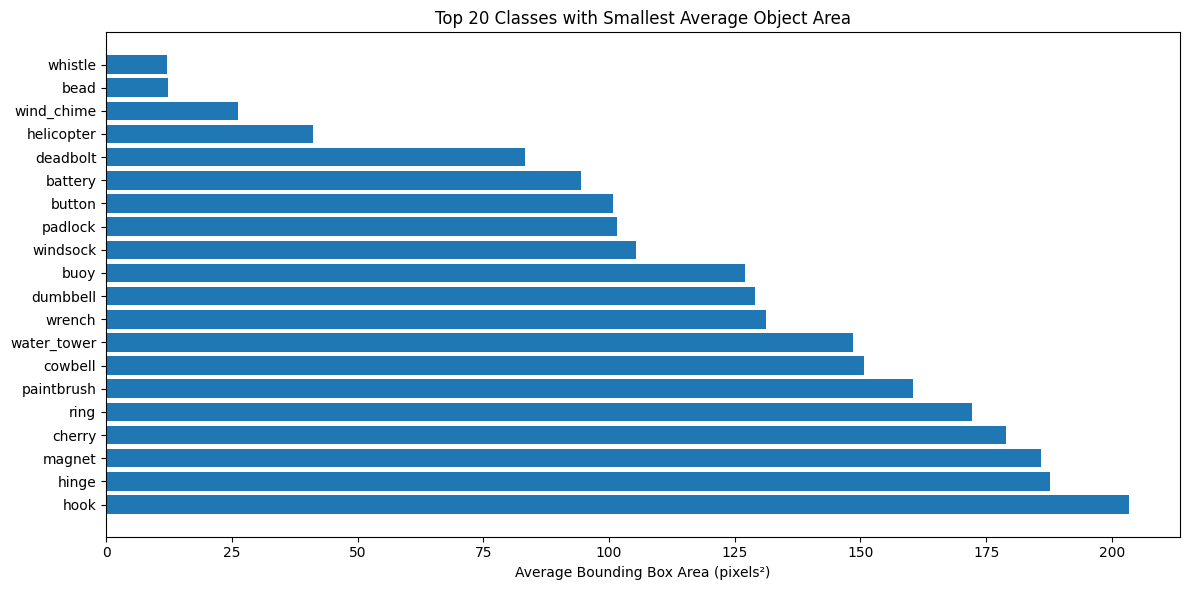

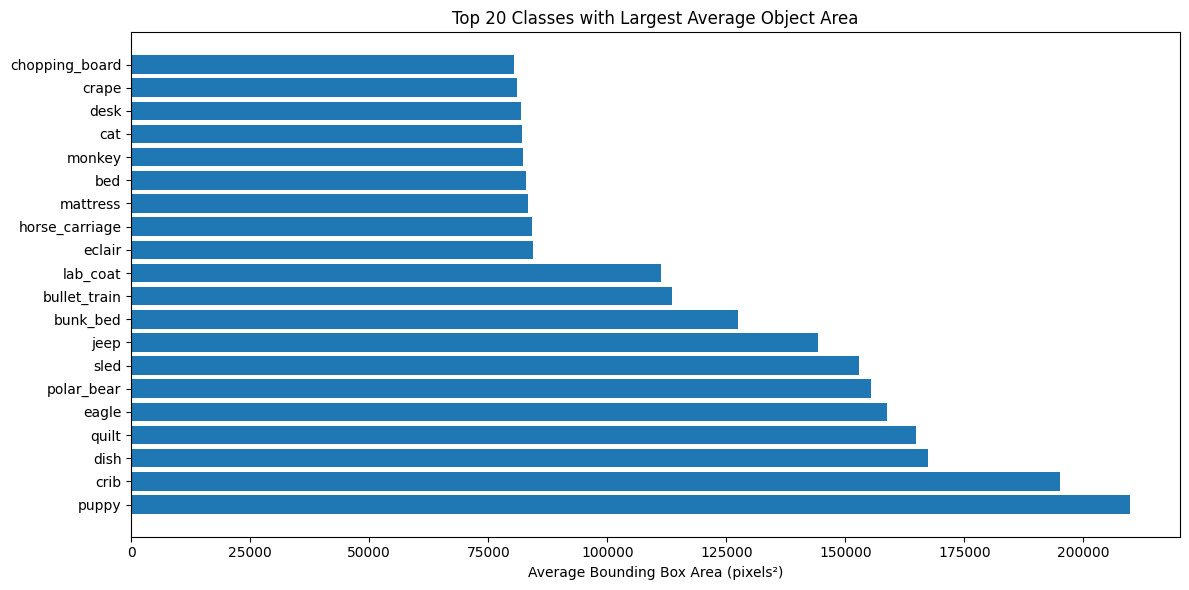

In [91]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Map class IDs to class names
id_to_name = {cat['id']: cat['name'] for cat in lvis_data['categories']}

# Step 2: Collect bbox areas per class
class_sizes = defaultdict(list)

for ann in lvis_data['annotations']:
    class_id = ann['category_id']
    area = ann['bbox'][2] * ann['bbox'][3]  # width × height
    class_sizes[class_id].append(area)

# Step 3: Compute average area per class
avg_class_sizes = {
    class_id: sum(areas) / len(areas)
    for class_id, areas in class_sizes.items()
}

# Step 4: Create a DataFrame for easy sorting and plotting
avg_size_df = pd.DataFrame([
    {
        "class_id": cid,
        "class_name": id_to_name[cid],
        "avg_area": avg_class_sizes[cid],
        "count": len(class_sizes[cid])
    }
    for cid in avg_class_sizes
])

# Step 5: Sort by average area
avg_size_df = avg_size_df.sort_values(by="avg_area")

# Step 6: Plot the top 20 classes with the smallest average area
plt.figure(figsize=(12, 6))
plt.barh(avg_size_df.head(20)["class_name"], avg_size_df.head(20)["avg_area"])
plt.xlabel("Average Bounding Box Area (pixels²)")
plt.title("Top 20 Classes with Smallest Average Object Area")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Optional: plot top 20 largest
plt.figure(figsize=(12, 6))
plt.barh(avg_size_df.tail(20)["class_name"], avg_size_df.tail(20)["avg_area"])
plt.xlabel("Average Bounding Box Area (pixels²)")
plt.title("Top 20 Classes with Largest Average Object Area")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()